Vamos a intentar encontrar que transacciones de la base de datos son fraudulentas. Las transacciones fraudulentas suelen ser uno de los principales problemas que las plataformas de pago o las fintech persiguen ya que tienen que cumplir con normas de compliance y tienen que ser transparentes entre otros motivos. Normalmente las transacciones fraudulentas suelen representar menos del 0,3% del total de las transacciones. 

En este caso hemos decidido que las siguientes características sean las más relevantes para detectar el fraude transaccional:

    1. Sólo aquellas transacciones con status "transaction_declined" o "rejected"

    2. Aquellas transacciones que tengan montos anormales, siguiendo con clientes que han hecho cash request de poca cantidad y de repente mucha cantidad o bien usuarios que solamente tengan una transacción y que sea un valor atípico de lo elevado que és.

    3. Usuarios inactivos que de repente hagan un cash request de mucha cantidad.

    4. Que la diferencia entre el created_at y el updated_at o el created_at y el paid_at sea muy pequeña.

    5. Transacciones a altas horas de la madrugada sin motivo aparente (1 AM a 4 AM).

    6. Muchas transacciones rechazadas antes de una transacción aprobada (secuencia sospechosa).

In [2]:
import os
os.chdir('codes')
%run analisis_calidad_datos.ipynb


Basic Information extract - cash request - data analyst.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          23970 non-null  int64  
 1   amount                      23970 non-null  float64
 2   status                      23970 non-null  object 
 3   created_at                  23970 non-null  object 
 4   updated_at                  23970 non-null  object 
 5   user_id                     21867 non-null  float64
 6   moderated_at                16035 non-null  object 
 7   deleted_account_id          2104 non-null   float64
 8   reimbursement_date          23970 non-null  object 
 9   cash_request_received_date  16289 non-null  object 
 10  money_back_date             16543 non-null  object 
 11  transfer_type               23970 non-null  object 
 12  send_at                    

In [3]:
# Filtrar los user_id con status "transaction_declined" o "rejected"
fraudulent_users = merged_df[merged_df['status'].isin(['transaction_declined', 'rejected'])]['user_id'].unique()

fraudulent_users


array([44498.0, 10562.0, 14048.0, 47557.0, 88127.0, 62880.0, 14832.0,
       27319.0, 526.0, 6333.0, 45517.0, 13565.0, 56860.0, 68367.0, 3248.0,
       34991.0, 69253.0, 76803.0, 83479.0, 96899.0], dtype=object)

In [4]:
# Filtrar los user_id con el amount máximo de 200
high_amount_users = merged_df[merged_df['amount'] == 200]['user_id'].unique()

high_amount_users


array([4881.0, 9282.0, 9222.0], dtype=object)

In [5]:
# Convertir las columnas de fechas a tipo datetime
merged_df['created_at'] = pd.to_datetime(merged_df['created_at'], errors='coerce')
merged_df['updated_at'] = pd.to_datetime(merged_df['updated_at'], errors='coerce')
merged_df['send_at'] = pd.to_datetime(merged_df['send_at'], errors='coerce')

# Calcular el diferencial de días entre created_at y updated_at
merged_df['days_created_to_updated'] = (merged_df['updated_at'] - merged_df['created_at']).dt.days

# Calcular el diferencial de días entre created_at y send_at
merged_df['days_created_to_send'] = (merged_df['send_at'] - merged_df['created_at']).dt.days

# Mostrar las nuevas columnas
merged_df[['created_at', 'updated_at', 'send_at', 'days_created_to_updated', 'days_created_to_send']]


,created_at,updated_at,send_at,days_created_to_updated,days_created_to_send
0,2020-10-23 15:20:26.163927+00:00,2020-12-18 13:08:29.099365+00:00,2020-10-23 15:21:26.878525+00:00,55,0.0
1,2020-05-27 02:26:27.615190+00:00,2020-06-09 11:25:51.726360+00:00,NaT,13,NaN
2,2020-07-01 09:30:03.145410+00:00,2020-08-11 22:27:58.240406+00:00,NaT,41,NaN
3,2020-07-01 09:30:03.145410+00:00,2020-08-11 22:27:58.240406+00:00,NaT,41,NaN
4,2020-07-01 09:30:03.145410+00:00,2020-08-11 22:27:58.240406+00:00,NaT,41,NaN
...,...,...,...,...,...
21052,2020-10-20 07:58:04.006937+00:00,2021-02-05 12:19:30.656816+00:00,2020-10-20 07:58:14.171553+00:00,108,0.0
21053,2020-10-10 05:40:55.700422+00:00,2021-02-05 13:14:19.707627+00:00,2020-10-10 05:41:23.368363+00:00,118,0.0
21054,2020-10-10 05:40:55.700422+00:00,2021-02-05 13:14:19.707627+00:00,2020-10-10 05:41:23.368363+00:00,118,0.0
21055,2020-10-08 14:16:52.155661+00:00,2021-01-05 15:45:52.645536+00:00,2020-10-08 14:17:04.526139+00:00,89,0.0


In [6]:
# Agrupar por 'user_id' y calcular el mínimo de 'days_created_to_updated' por cada usuario
grouped_users = merged_df.groupby('user_id')['days_created_to_updated'].min()

# Ordenar los resultados y obtener los 20 con el menor valor
top_20_users_grouped = grouped_users.nsmallest(19)

top_20_users_grouped



user_id
526.0      0
3248.0     0
6333.0     0
10562.0    0
13565.0    0
14048.0    0
14832.0    0
34991.0    0
44498.0    0
45517.0    0
47557.0    0
56860.0    0
62880.0    0
68367.0    0
69253.0    0
76803.0    0
83479.0    0
88127.0    0
96899.0    0
Name: days_created_to_updated, dtype: int64

In [7]:
# Convertir la columna 'created_at' a tipo datetime si no lo está
merged_df['created_at'] = pd.to_datetime(merged_df['created_at'], errors='coerce')

# Extraer la hora de la columna 'created_at'
merged_df['hour_created'] = merged_df['created_at'].dt.hour

# Filtrar los user_id con transacciones realizadas entre la 1AM y las 4AM
filtered_users = merged_df[(merged_df['hour_created'] >= 1) & (merged_df['hour_created'] < 4)]['user_id'].unique()

filtered_users


array([2109.0, 6536.0, 26912.0, 11905.0, 33465.0, 'Null', 20230.0,
       62302.0, 24547.0, 28404.0, 92043.0, 87807.0, 35354.0, 24144.0,
       13735.0, 79903.0, 9917.0, 26764.0, 5264.0, 30956.0, 65693.0,
       27319.0, 38898.0, 19667.0, 77635.0, 21354.0, 6164.0, 56475.0,
       53742.0, 98130.0, 4982.0, 12070.0, 48917.0, 8093.0, 56093.0,
       22510.0, 1987.0, 1776.0, 18708.0, 17697.0, 31241.0, 34635.0,
       32822.0, 86082.0, 52482.0, 65328.0, 3219.0, 47267.0, 7302.0,
       8746.0, 93714.0, 4656.0, 1658.0, 17707.0, 3287.0, 14750.0, 10028.0,
       30112.0, 10522.0, 77311.0, 87976.0, 80521.0, 82814.0, 18369.0,
       12015.0, 1136.0, 32407.0, 12353.0, 6938.0, 25158.0, 12233.0,
       10432.0, 17725.0, 8196.0, 430.0, 87479.0, 34496.0, 5291.0, 9852.0,
       47851.0, 590.0, 14617.0, 5189.0, 23971.0, 9973.0, 192.0, 3631.0,
       34928.0, 34872.0, 17925.0, 20836.0, 19579.0, 30377.0, 3121.0,
       33406.0, 19753.0, 20926.0, 29652.0, 8496.0, 12103.0, 35990.0,
       25095.0, 10177.0, 

In [11]:
# Filtrar los user_id con status "transaction_declined" o "direct_debit_rejected"
filtered_status_users = merged_df[
    merged_df['status'].isin(['transaction_declined', 'direct_debit_rejected'])
]['user_id'].nunique()

filtered_status_users

725

In [8]:
# Obtener los user_id con status "transaction_declined" o "direct_debit_rejected"
filtered_user_ids = merged_df[
    merged_df['status'].isin(['transaction_declined', 'direct_debit_rejected'])
]['user_id'].unique()

filtered_user_ids


array([15415.0, 16861.0, 28368.0, 14484.0, 58270.0, 8379.0, 95574.0,
       9748.0, 6976.0, 32634.0, 41200.0, 74867.0, 2575.0, 5296.0, 17851.0,
       88936.0, 13261.0, 5206.0, 12513.0, 6561.0, 2715.0, 44498.0, 8866.0,
       33064.0, 5299.0, 33866.0, 13778.0, 10562.0, 16730.0, 17580.0,
       15057.0, 25246.0, 88757.0, 17343.0, 13863.0, 4552.0, 16115.0,
       96836.0, 12485.0, 15570.0, 7780.0, 22274.0, 69977.0, 13637.0,
       27978.0, 32758.0, 11967.0, 4825.0, 23754.0, 60572.0, 42918.0,
       34591.0, 31556.0, 57440.0, 98604.0, 42862.0, 28868.0, 14048.0,
       4305.0, 32873.0, 72204.0, 17751.0, 1909.0, 19060.0, 5331.0,
       34460.0, 'Null', 25080.0, 99347.0, 20859.0, 60704.0, 10123.0,
       5496.0, 33541.0, 5186.0, 52193.0, 79660.0, 12699.0, 20820.0,
       4644.0, 6569.0, 27321.0, 24547.0, 30009.0, 30131.0, 30364.0,
       26802.0, 36981.0, 43191.0, 14638.0, 97197.0, 36366.0, 57193.0,
       28404.0, 62776.0, 59840.0, 40226.0, 12664.0, 32220.0, 17995.0,
       87807.0, 98556.0

In [12]:
# Convertir cada lista de user_id en un conjunto
fraudulent_users_set = set(fraudulent_users)
high_amount_users_set = set(high_amount_users)
top_20_users_grouped_set = set(top_20_users_grouped.index)  # Si es un DataFrame con índice user_id
filtered_users_set = set(filtered_users)
filtered_status_users_set = set([filtered_status_users])  # Solo un valor si es un conteo
filtered_user_ids_set = set(filtered_user_ids)

# Unir todos los conjuntos
all_sets = [
    fraudulent_users_set,
    high_amount_users_set,
    top_20_users_grouped_set,
    filtered_users_set,
    filtered_user_ids_set,
]

# Encontrar intersecciones y usuarios únicos
from collections import Counter

# Contar cuántos conjuntos contienen cada user_id
user_id_counter = Counter(user_id for user_set in all_sets for user_id in user_set)

# Filtrar los user_id que aparecen en más de un conjunto
common_users = {user_id: count for user_id, count in user_id_counter.items() if count > 1}

common_users


{76803.0: 3,
 96899.0: 3,
 69253.0: 3,
 526.0: 3,
 68367.0: 3,
 83479.0: 3,
 56860.0: 3,
 62880.0: 3,
 34991.0: 3,
 3248.0: 3,
 27319.0: 3,
 6333.0: 3,
 88127.0: 3,
 10562.0: 3,
 47557.0: 3,
 45517.0: 3,
 44498.0: 3,
 14048.0: 3,
 14832.0: 3,
 13565.0: 3,
 31241.0: 2,
 10766.0: 2,
 'Null': 2,
 93714.0: 2,
 79903.0: 2,
 11832.0: 2,
 86082.0: 2,
 24144.0: 2,
 47267.0: 2,
 7379.0: 2,
 18664.0: 2,
 28404.0: 2,
 87807.0: 2,
 52482.0: 2,
 18708.0: 2,
 48917.0: 2,
 12070.0: 2,
 77635.0: 2,
 34635.0: 2,
 24547.0: 2,
 53742.0: 2}

In [13]:
# Lista de user_id con 3 métricas fraudulentas
fraudulent_user_ids = [76803.0, 96899.0, 69253.0, 526.0, 68367.0, 83479.0, 
                       56860.0, 62880.0, 34991.0, 3248.0, 27319.0, 6333.0, 
                       88127.0, 10562.0, 47557.0, 45517.0, 44498.0, 14048.0, 
                       14832.0, 13565.0]

# Filtrar las filas correspondientes a estos user_id en el DataFrame
fraudulent_users_data = merged_df[merged_df['user_id'].isin(fraudulent_user_ids)]

fraudulent_users_data


,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,...,reason_fee,created_at_fee,updated_at_fee,paid_at_fee,from_date_fee,to_date_fee,charge_moment_fee,days_created_to_updated,days_created_to_send,hour_created
314,23641,100.0,transaction_declined,2020-10-23 16:32:14.856670+00:00,2020-10-23 16:33:15.530982+00:00,44498.0,98,98888888.0,2020-11-05 22:00:00+00,98,...,Instant Payment Cash Request 23641,2020-10-23 16:32:34.165305+00:00,2020-10-23 16:32:34.165333+00,Null,98,98,after,0,0.0,16
368,20843,100.0,transaction_declined,2020-10-13 11:37:39.099076+00:00,2020-10-13 11:38:15.006014+00:00,10562.0,98,98888888.0,2020-11-04 22:00:00+00,98,...,Instant Payment Cash Request 20843,2020-10-13 11:37:48.589518+00:00,2020-10-13 14:25:19.178819+00,Null,98,98,after,0,0.0,11
591,21867,50.0,transaction_declined,2020-10-17 22:07:44.901479+00:00,2020-10-17 22:08:26.283793+00:00,14048.0,98,98888888.0,2020-11-06 22:00:00+00,98,...,Instant Payment Cash Request 21867,2020-10-17 22:08:07.068550+00:00,2020-10-17 22:08:07.068579+00,Null,98,98,after,0,0.0,22
1086,15648,100.0,canceled,2020-09-11 06:16:16.095653+00:00,2020-09-15 09:27:48.076160+00:00,10562.0,98,98888888.0,2020-10-05 22:00:00+00,98,...,Instant Payment Cash Request 15648,2020-09-11 06:53:30.979718+00:00,2020-10-13 14:25:10.362597+00,Null,98,98,after,4,6.0,6
1108,16070,100.0,money_back,2020-09-14 13:13:07.251900+00:00,2020-12-18 13:08:32.308293+00:00,526.0,2020-09-14 16:58:51.617615+00,98888888.0,2020-10-13 22:00:00+00,2020-09-15,...,Instant Payment Cash Request 16070,2020-09-14 16:59:02.063951+00:00,2020-10-13 14:25:11.32745+00,2020-10-06 14:50:29.637469+00,98,98,after,94,6.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16335,20672,45.0,money_back,2020-10-12 18:02:24.648678+00:00,2020-12-18 13:12:30.756440+00:00,6333.0,98,98888888.0,2020-11-05 22:00:00+00,98,...,Instant Payment Cash Request 20672,2020-10-12 18:02:36.499763+00:00,2020-10-13 14:25:18.938869+00,2020-11-05 20:43:02.604818+00,98,98,after,66,0.0,18
17613,20665,90.0,money_back,2020-10-12 17:22:01.397186+00:00,2020-12-18 13:12:56.300378+00:00,526.0,2020-10-13 07:45:01.30784+00,98888888.0,2020-11-10 23:00:00+00,2020-10-14,...,Postpone Cash Request 20665,2020-10-26 18:40:10.764100+00:00,2020-10-26 18:40:10.76413+00,2020-10-26 18:40:15.358285+00,2020-10-29 22:00:00+00,2020-11-10 23:00:00+00,before,66,0.0,17
17614,20665,90.0,money_back,2020-10-12 17:22:01.397186+00:00,2020-12-18 13:12:56.300378+00:00,526.0,2020-10-13 07:45:01.30784+00,98888888.0,2020-11-10 23:00:00+00,2020-10-14,...,Instant Payment Cash Request 20665,2020-10-13 07:45:03.154446+00:00,2020-10-13 14:25:19.070652+00,2020-10-28 23:26:54.021906+00,98,98,after,66,0.0,17
17806,26720,100.0,money_back,2020-10-31 12:46:40.831215+00:00,2020-12-18 13:13:00.799160+00:00,526.0,2020-10-31 14:59:13.307943+00,98888888.0,2020-11-27 23:51:00+00,2020-11-01,...,Instant Payment Cash Request 26720,2020-10-31 14:59:15.093577+00:00,2020-10-31 14:59:15.093604+00,2020-11-28 19:41:04.411337+00,98,98,after,48,0.0,12


In [ ]:
# Crear columna 'fraudulent_flag' en el dataframe base
fraudulent_user_ids = fraudulent_users_data['user_id'].unique()
merged_df['fraudulent_flag'] = merged_df['user_id'].apply(
    lambda x: 1 if x in fraudulent_user_ids else 0
)


In [16]:
# Características seleccionadas
features = ['amount', 'transfer_type', 'days_created_to_updated']

# Codificar variables categóricas y preparar el dataset
df_model = merged_df[features + ['fraudulent_flag']]
df_model = pd.get_dummies(df_model, columns=['transfer_type'], drop_first=True)


In [17]:
from sklearn.model_selection import train_test_split

# Separar X (características) e y (etiquetas)
X = df_model.drop('fraudulent_flag', axis=1)
y = df_model['fraudulent_flag']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
from sklearn.tree import DecisionTreeClassifier

# Entrenar el modelo
model = DecisionTreeClassifier(random_state=42, max_depth=5)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

# Hacer predicciones
y_pred = model.predict(X_test)

# Reporte de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4186
           1       0.89      0.31      0.46        26

    accuracy                           1.00      4212
   macro avg       0.94      0.65      0.73      4212
weighted avg       1.00      1.00      0.99      4212

[[4185    1]
 [  18    8]]


In [20]:
from sklearn.model_selection import GridSearchCV

# Definir hiperparámetros para ajustar
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Entrenar GridSearchCV
grid_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Evaluar con el mejor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Reporte de métricas
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4186
           1       0.73      0.31      0.43        26

    accuracy                           1.00      4212
   macro avg       0.86      0.65      0.71      4212
weighted avg       0.99      1.00      0.99      4212

[[4183    3]
 [  18    8]]


In [21]:
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Entrenar el modelo con los mejores hiperparámetros
best_model_smote = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)
best_model_smote.fit(X_resampled, y_resampled)

# Evaluar el modelo en el conjunto de prueba
y_pred_smote = best_model_smote.predict(X_test)

# Reporte de métricas
print(classification_report(y_test, y_pred_smote))
print(confusion_matrix(y_test, y_pred_smote))


              precision    recall  f1-score   support

           0       1.00      0.90      0.95      4186
           1       0.03      0.54      0.06        26

    accuracy                           0.90      4212
   macro avg       0.51      0.72      0.50      4212
weighted avg       0.99      0.90      0.94      4212

[[3773  413]
 [  12   14]]


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Crear modelo Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)

# 2. Entrenar modelo con datos balanceados
rf_model.fit(X_resampled, y_resampled)

# 3. Predicciones
y_pred_rf = rf_model.predict(X_test)

# 4. Evaluar resultados
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_rf))


Matriz de confusión:
[[3999  187]
 [  11   15]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      4186
           1       0.07      0.58      0.13        26

    accuracy                           0.95      4212
   macro avg       0.54      0.77      0.55      4212
weighted avg       0.99      0.95      0.97      4212



In [23]:
from sklearn.metrics import classification_report, confusion_matrix

# Predicciones de probabilidad en lugar de predicción directa
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidades de clase 1 (fraudulenta)

# Ajuste de umbral: por ejemplo, utilizando un umbral de 0.2 en lugar de 0.5
threshold = 0.2
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)  # Convertir a 0 o 1 según el umbral

# Mostrar la matriz de confusión y reporte de clasificación con el nuevo umbral
print("Matriz de confusión ajustada:")
print(confusion_matrix(y_test, y_pred_adjusted))

print("\nReporte de clasificación ajustado:")
print(classification_report(y_test, y_pred_adjusted))


Matriz de confusión ajustada:
[[4181    5]
 [  17    9]]

Reporte de clasificación ajustado:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4186
           1       0.64      0.35      0.45        26

    accuracy                           0.99      4212
   macro avg       0.82      0.67      0.72      4212
weighted avg       0.99      0.99      0.99      4212



In [25]:
# Suponiendo que X_test corresponde al conjunto de prueba de merged_df (solo las filas de prueba)
# Primero, obtener las probabilidades para la clase 1 (fraudulenta)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidad de la clase 1 (fraudulenta)

# Aplicar el umbral ajustado de 0.2
y_pred_adjusted = (y_pred_proba >= 0.2).astype(int)

# Filtrar los 'user_id' del conjunto de prueba donde la predicción es fraudulenta (clase 1)
# Asegúrate de que merged_df tiene la misma longitud que el conjunto de prueba X_test
fraudulent_users = merged_df.iloc[X_test.index][y_pred_adjusted == 1]['user_id']

# Mostrar los primeros 9 usuarios fraudulentos
fraudulent_users.head(9)



1978    47557.0
1807    10562.0
1713    62880.0
2267    83479.0
828     14611.0
1815    10562.0
1805    36455.0
1606    62880.0
1712    62880.0
Name: user_id, dtype: object

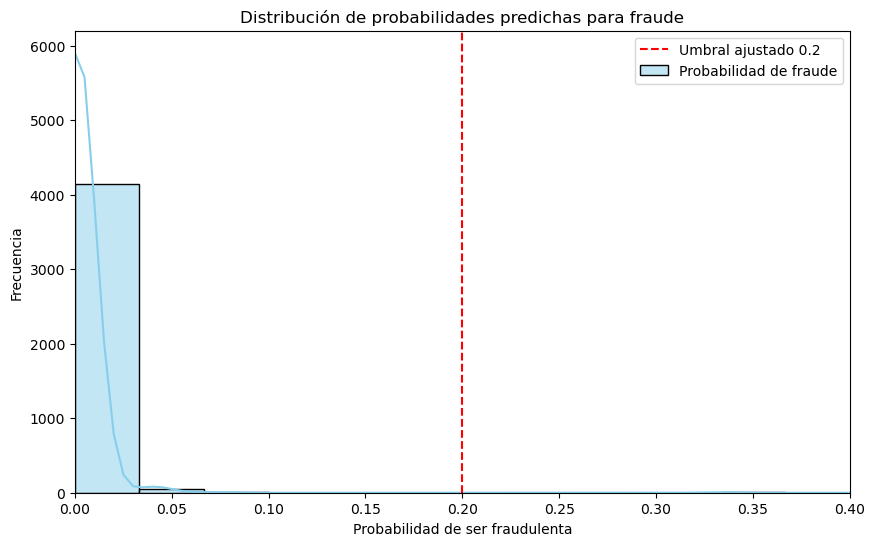

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma de probabilidades para clase 0 (no fraudulenta) y clase 1 (fraudulenta)
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_proba, kde=True, color="skyblue", bins=30, label="Probabilidad de fraude")

# Ajustar el límite del eje X a 0.4, ya que el umbral es 0.2
plt.xlim(0, 0.4)

# Añadir línea vertical en el umbral ajustado (0.2)
plt.axvline(x=0.2, color='red', linestyle='--', label="Umbral ajustado 0.2")

# Añadir etiquetas y título
plt.title('Distribución de probabilidades predichas para fraude')
plt.xlabel('Probabilidad de ser fraudulenta')
plt.ylabel('Frecuencia')

# Mostrar la leyenda
plt.legend()
plt.show()



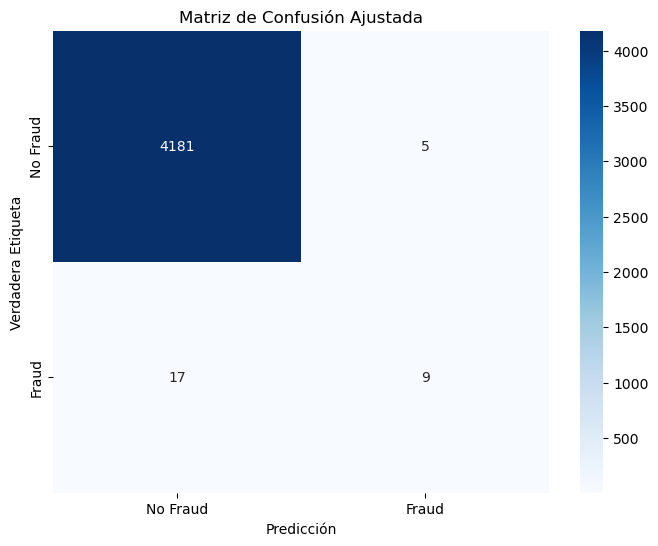

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_adjusted)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.title('Matriz de Confusión Ajustada')
plt.xlabel('Predicción')
plt.ylabel('Verdadera Etiqueta')
plt.show()


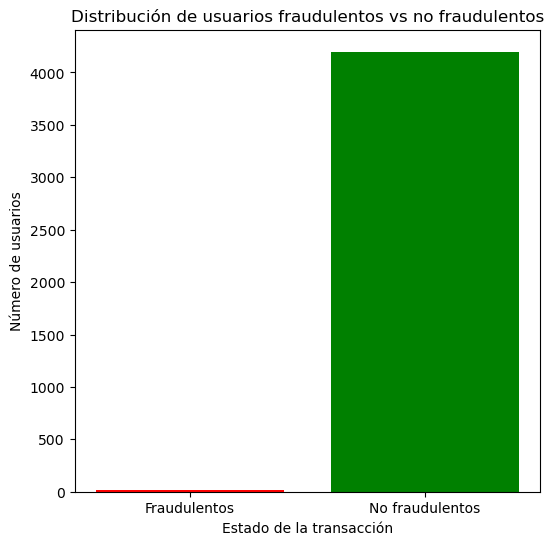

In [28]:
# Calcular la cantidad de usuarios fraudulentos y no fraudulentos
fraud_count = sum(y_pred_adjusted == 1)
non_fraud_count = sum(y_pred_adjusted == 0)

# Graficar la distribución
plt.figure(figsize=(6, 6))
plt.bar(['Fraudulentos', 'No fraudulentos'], [fraud_count, non_fraud_count], color=['red', 'green'])
plt.title('Distribución de usuarios fraudulentos vs no fraudulentos')
plt.xlabel('Estado de la transacción')
plt.ylabel('Número de usuarios')
plt.show()


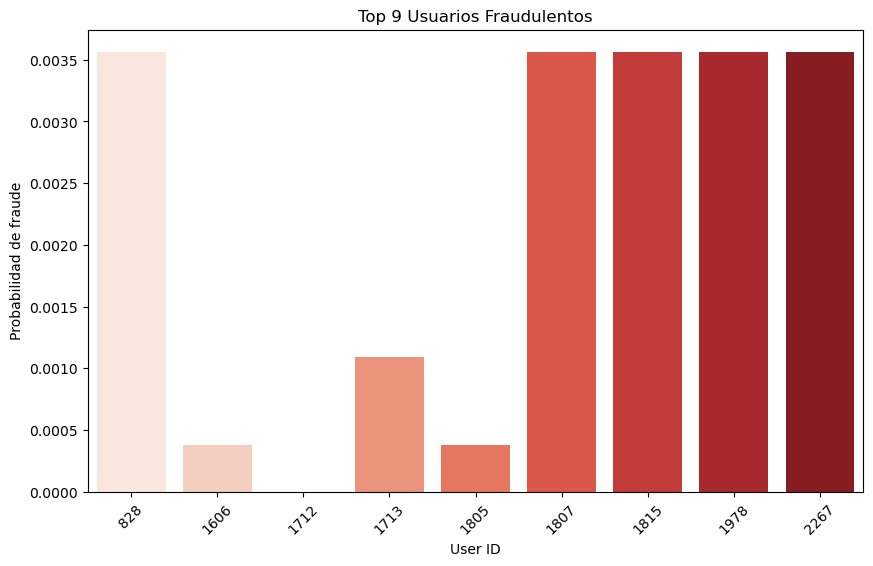

In [29]:
# Obtener los primeros 9 usuarios fraudulentos
top_fraudulent_users = fraudulent_users.head(9)

# Graficar los usuarios fraudulentos
plt.figure(figsize=(10, 6))
sns.barplot(x=top_fraudulent_users.index, y=y_pred_proba[top_fraudulent_users.index], palette="Reds")
plt.title('Top 9 Usuarios Fraudulentos')
plt.xlabel('User ID')
plt.ylabel('Probabilidad de fraude')
plt.xticks(rotation=45)
plt.show()


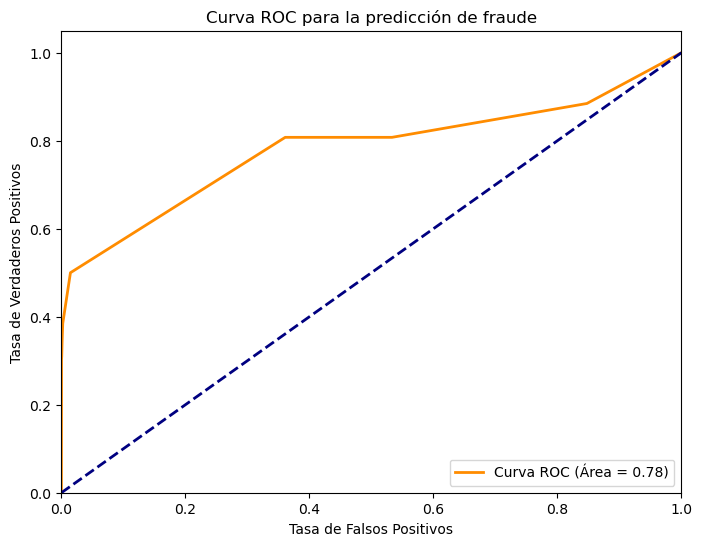

In [30]:
from sklearn.metrics import roc_curve, auc

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (Área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para la predicción de fraude')
plt.legend(loc="lower right")
plt.show()


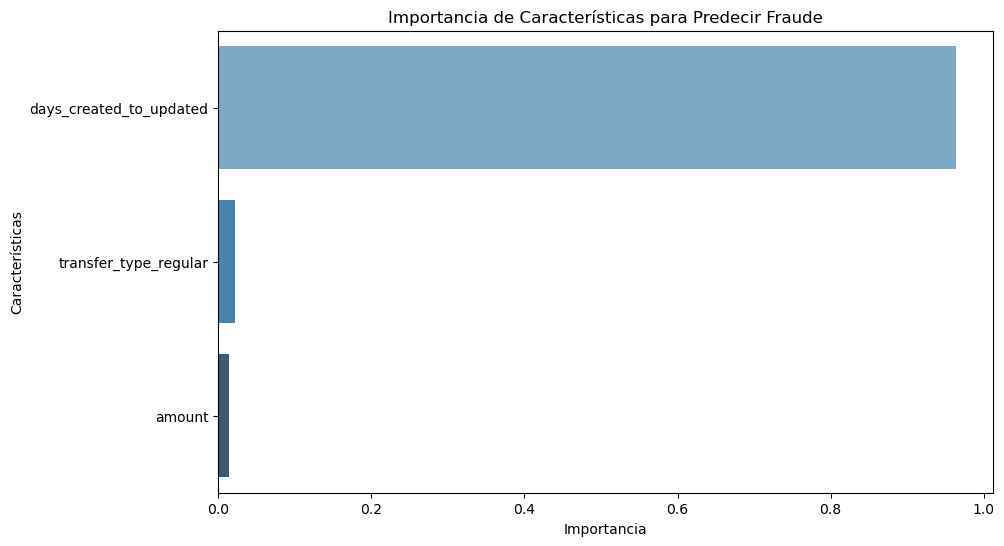

In [31]:
import numpy as np

# Importancia de características
feature_importances = model.feature_importances_

# Crear un gráfico de barras para mostrar las características más importantes
features = X_train.columns
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[indices], y=features[indices], palette='Blues_d')
plt.title('Importancia de Características para Predecir Fraude')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()
